# Analysis of the Historical Price of Bitcoin

## Setup

In [1]:
import calendar
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

In [3]:
# Get bitcoin df with date as index
df_btc = pd.read_csv("../data/BTC.csv", index_col="date", parse_dates=True)

## Bitcoin Price Over Time ₿

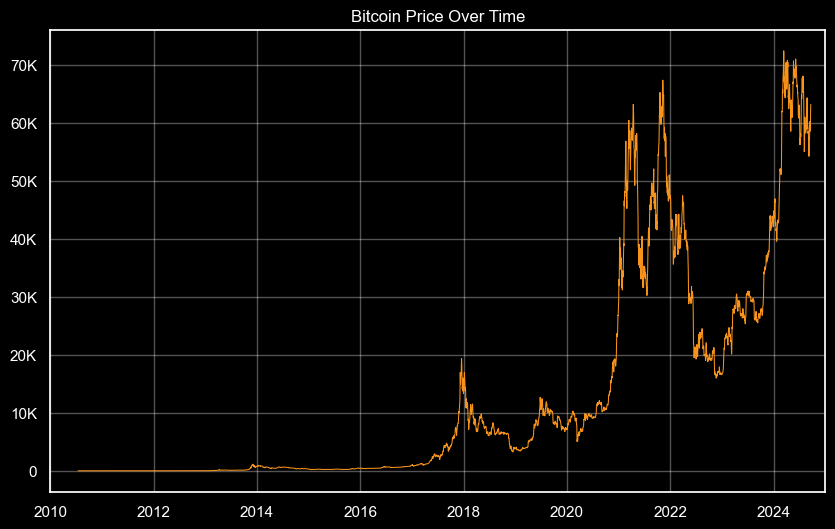

In [4]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_btc, x=df_btc.index, y="price", color="#f7931a", linewidth=0.75)

plt.xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2025-01-01"))

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer() 
                  else f"{x:.1f}" if x < 1 else f"{int(x / 1000)}K")
)

plt.title("Bitcoin Price Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("1_BTC_price")

**To make it possible to see the early price fluctuations we need a logarithmic scale on the y-axis.**

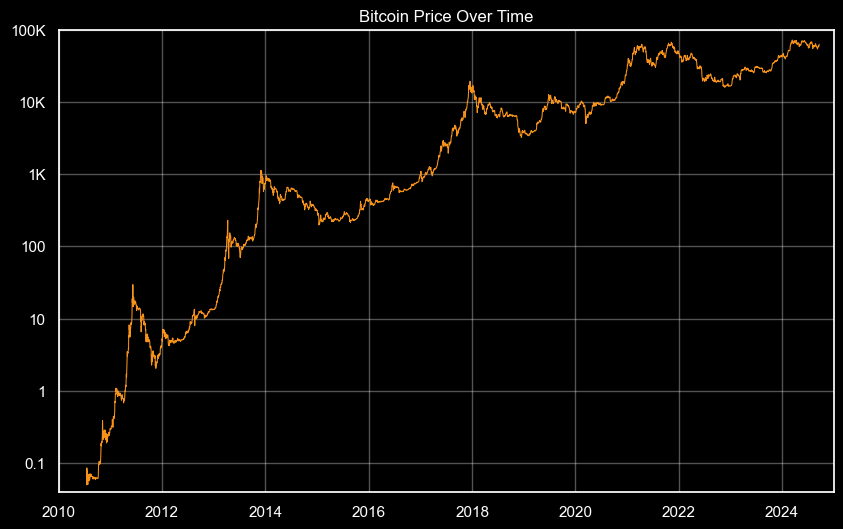

In [5]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_btc, x=df_btc.index, y="price", color="#f7931a", linewidth=0.75)

plt.yscale("log")
plt.xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2025-01-01"))
plt.ylim(0.04, 100_000)

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer() 
                  else f"{x:.1f}" if x < 1 else f"{int(x / 1000)}K")
)

plt.title("Bitcoin Price Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("1_BTC_price_log")

In [6]:
# All-time high
ath_date = df_btc["price"].idxmax()
df_btc.loc[[ath_date]]

,price
date,
2024-03-13,72372.82


In [7]:
# All-time low
atl_date = df_btc["price"].idxmin()
df_btc.loc[[atl_date]]

,price
date,
2010-07-17,0.05


In [8]:
# Peaks
peaks, _ = signal.find_peaks(df_btc["price"], distance=365)
df_btc.iloc[peaks].nlargest(12, "price").sort_values("date")[["price"]].T

date,2011-06-08,2012-08-16,2013-11-30,2014-12-02,2015-12-12,2016-12-13,2017-12-17,2019-06-26,2020-11-06,2021-11-09,2023-03-14,2024-03-13
price,29.6,13.5,1130.3875,380.71425,441.91,782.023,19340.535552,12661.812254,15565.937519,67314.9024,24770.498981,72372.82


In [9]:
# Valleys
valleys, _ = signal.find_peaks(-df_btc["price"], distance=365)
df_btc.iloc[valleys].nsmallest(12, "price").sort_values("date")[["price"]].T

date,2010-07-22,2011-11-18,2012-11-18,2013-11-20,2015-01-15,2016-02-03,2017-03-25,2018-12-15,2020-03-13,2021-07-20,2022-11-22,2023-11-22
price,0.0505,2.05,11.6515,554.2275,198.63725,371.858,947.94825,3235.732186,5053.456191,30218.1425,15970.745919,36696.7525


In [10]:
# Price appreciation since first entry
first_entry_price = df_btc.iloc[0]["price"]
last_entry_price = df_btc.iloc[-1]["price"]
(last_entry_price / first_entry_price) - 1

1262458.55

In [11]:
# How many times the price has multiplied since the first entry
last_entry_price / first_entry_price

1262459.55

**Key takeaways:**
- The all-time low occurred at the very beginning of the dataset, with bitcoin trading around 5 cents.
- From there, the price rose rapidly, peaking in mid-2011.
- In 2013, bitcoin gained significant mainstream attention, going viral and breaking its previous all-time high, peaking by the end of the year.
- After three years of relatively low activity, bitcoin went viral again in 2017, reaching nearly \$20k.
- The market remained quiet from 2018 to 2020, with minimal performance until bitcoin regained momentum in late 2020, going viral once again.
- Following a sharp collapse in 2022, bitcoin rebounded quickly, reaching a new all-time high of around \$72.4k in March 2024.
- Since the first entry, bitcoin's price has skyrocketed by nearly 126,245,855%, meaning its initial value has multiplied by about 1,262,460 times.

## Major Market Cycles of Bitcoin Over Time 🔄

In [12]:
# Get df with main rallies and crashes
def get_price_change(first_date: str, last_date: str) -> tuple[float, float]:
    first_price = df_btc.loc[first_date, "price"]
    last_price = df_btc.loc[last_date, "price"]
    price_change = last_price - first_price
    price_change_pct = last_price / first_price - 1
    return price_change, price_change_pct

timeframes = [("2010-07-22", "2011-06-08"),
              ("2011-06-08", "2011-11-18"),
              ("2011-11-18", "2013-11-30"),
              ("2013-11-30", "2015-01-15"),
              ("2015-01-15", "2017-12-17"),
              ("2017-12-17", "2018-12-15"),
              ("2018-12-15", "2021-11-09"),
              ("2021-11-09", "2022-11-22")]

price_changes = []
price_changes_pcts = []
days = []
formatted_timeframes = []

for first_date, last_date in timeframes:
    price_change, price_change_pct = get_price_change(first_date, last_date)
    price_changes.append(price_change)
    price_changes_pcts.append(price_change_pct)
    days.append((pd.to_datetime(last_date) - pd.to_datetime(first_date)).days)
    formatted_timeframes.append(f"{first_date} - {last_date}")

df_btc_cycles = pd.DataFrame({
    "timeframe": formatted_timeframes,
    "price_change": price_changes,
    "price_change_pct": price_changes_pcts,
    "days": days,
})
df_btc_cycles

,timeframe,price_change,price_change_pct,days
0,2010-07-22 - 2011-06-08,29.549500,585.138614,321
1,2011-06-08 - 2011-11-18,-27.550000,-0.930743,163
2,2011-11-18 - 2013-11-30,1128.337500,550.408537,743
3,2013-11-30 - 2015-01-15,-931.750250,-0.824275,411
4,2015-01-15 - 2017-12-17,19141.898302,96.366106,1067
5,2017-12-17 - 2018-12-15,-16104.803366,-0.832697,363
6,2018-12-15 - 2021-11-09,64079.170214,19.803608,1060
7,2021-11-09 - 2022-11-22,-51344.156481,-0.762746,378


In [13]:
# Get year-month timeframe
df_btc_cycles["timeframe_ym"] = df_btc_cycles["timeframe"].apply(lambda x: f"{x[:7]} - {x[13:20]}")

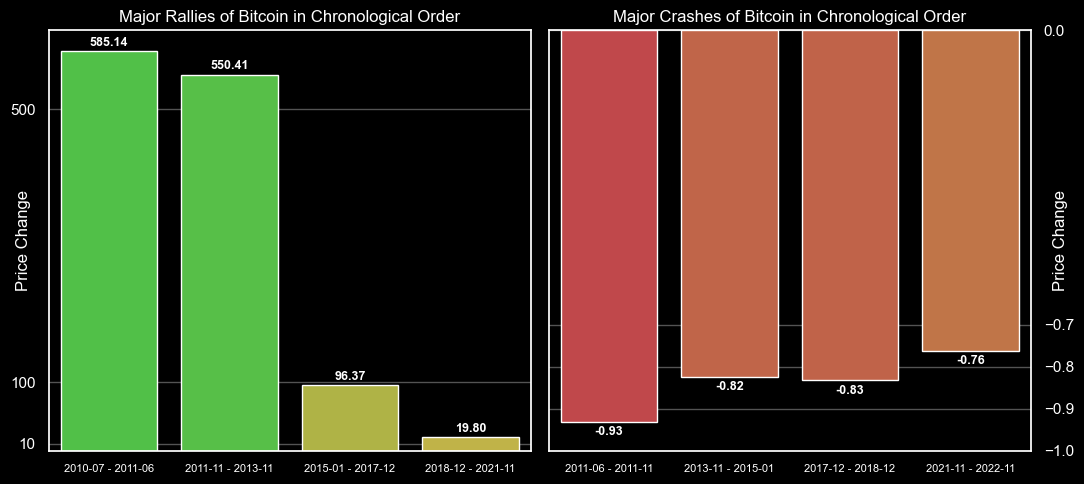

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Create a custom palette for each chart
palette_greens = LinearSegmentedColormap.from_list("rallies",["#d4c334", "#40d434"])
palette_reds = LinearSegmentedColormap.from_list("crashes", ["#d43438", "#d47034"])

ax_1 = sns.barplot(data=df_btc_cycles.loc[df_btc_cycles["price_change_pct"] > 0], x="timeframe_ym", y="price_change_pct", ax=axes[0], palette=palette_greens, hue="price_change_pct", legend=False)
ax_2 = sns.barplot(data=df_btc_cycles.loc[df_btc_cycles["price_change_pct"] < 0], x="timeframe_ym", y="price_change_pct", ax=axes[1], palette=palette_reds, hue="price_change_pct", legend=False)

# Configure axes[0] (Rallies)
axes[0].set_ylim(0, 615)
axes[0].set_yticks([10, 100, 500])
axes[0].set_title("Major Rallies of Bitcoin in Chronological Order")
axes[0].set_xlabel(None)
axes[0].set_ylabel("Price Change", labelpad=-15)

# Configure axes[1] (Crashes)
axes[1].set_ylim(-1, 0)
axes[1].set_yticks([-1, -0.9, -0.8, -0.7, 0])
axes[1].set_title("Major Crashes of Bitcoin in Chronological Order")
axes[1].set_xlabel(None)
axes[1].set_ylabel("Price Change", labelpad=-15)
axes[1].yaxis.set_label_position("right")
axes[1].tick_params(axis="y", labelleft=False, labelright=True)

# Adjust x-axis tick sizes for both axes
[ax.tick_params(axis="x", labelsize=8) for ax in axes]

# Label each bar with its value
font_properties = font_manager.FontProperties(family="sans-serif", weight="bold", size=9)
for container in ax_1.containers:
    ax_1.bar_label(container, fmt="%.2f", padding=1.5, fontproperties=font_properties)
for container in ax_2.containers:
    ax_2.bar_label(container, fmt="%.2f", padding=3, fontproperties=font_properties)
    
plt.tight_layout()

save_chart_as_png("1_BTC_major_cycles")

**Key takeaways:**
- Bitcoin's price is known for its extreme volatility, often experiencing dramatic surges in value followed by steep declines of up to 80-90%.
- The first bull market saw the most significant price increase, soaring by approximately 58,514% in less than a year. Given the diminishing returns in subsequent rallies, it's unlikely this record will be surpassed.
- The first bear market was equally extreme, with bitcoin losing about 93% of its value in just 163 days.
- The second rally came close to the first in percentage gains, though it took two years to unfold.
- Throughout the years, both bull and bear markets have become less intense, especially the bull phases, reflecting a gradual loss of momentum.
- Although the last surge was weaker compared to previous cycles, it still showed a remarkable gain of approximately 1,980%, achieved over nearly 3 years.

## STL Decomposition (Trend, Seasonality, and Residuals) 📈

In [15]:
stl = STL(df_btc["price"], period=365).fit()

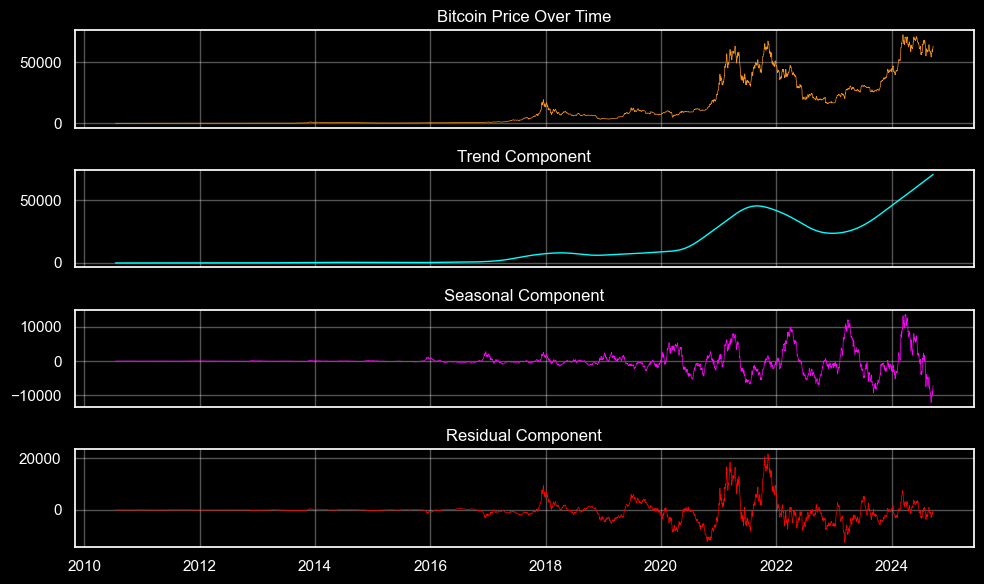

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df_btc.index, df_btc["price"], label="Original", color="#f7931a", linewidth=0.5)
axes[1].plot(df_btc.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[2].plot(df_btc.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[3].plot(df_btc.index, stl.resid, label="Residual", color="red", linewidth=0.5)

axes[0].set_title("Bitcoin Price Over Time")
axes[1].set_title("Trend Component")
axes[2].set_title("Seasonal Component")
axes[3].set_title("Residual Component")

plt.tight_layout()

### Trend Analysis

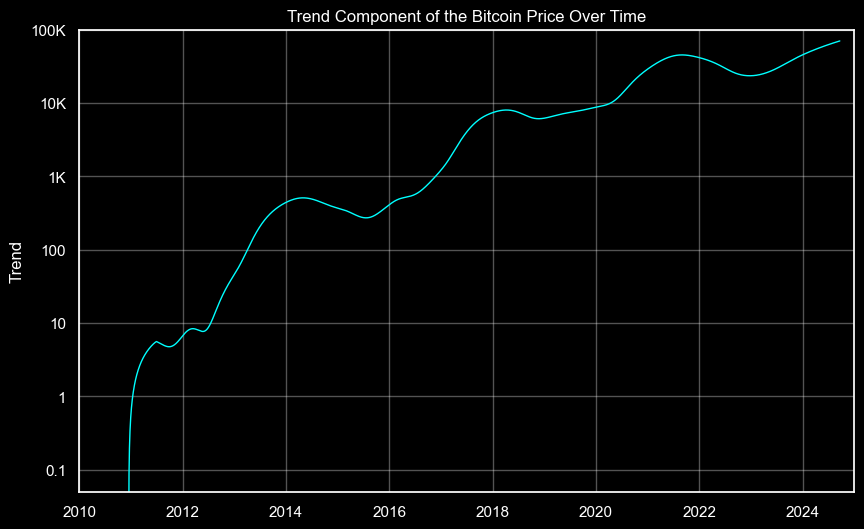

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.yscale("log")
plt.xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2025-01-01"))
plt.ylim(df_btc.min()["price"], 100_000)

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer() 
                  else (f"{x:.1f}" if x < 1 else f"{int(x/1000)}K"))
)

plt.title("Trend Component of the Bitcoin Price Over Time")
plt.xlabel(None)
plt.ylabel("Trend")

save_chart_as_png("1_BTC_trend")

**Key takeaways:**
- The trend saw massive growth up until 2014.
- Since then, bitcoin has been rising consistently, although with progressively less momentum.
- Bitcoin's viral surges are clearly visible, with each bounce decreasing in magnitude, indicating increased stability as the years go by.
- Overall, the long-term trend appears to follow a logarithmic growth pattern.

### Seasonality Analysis

In [18]:
# Get average seasonal component
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

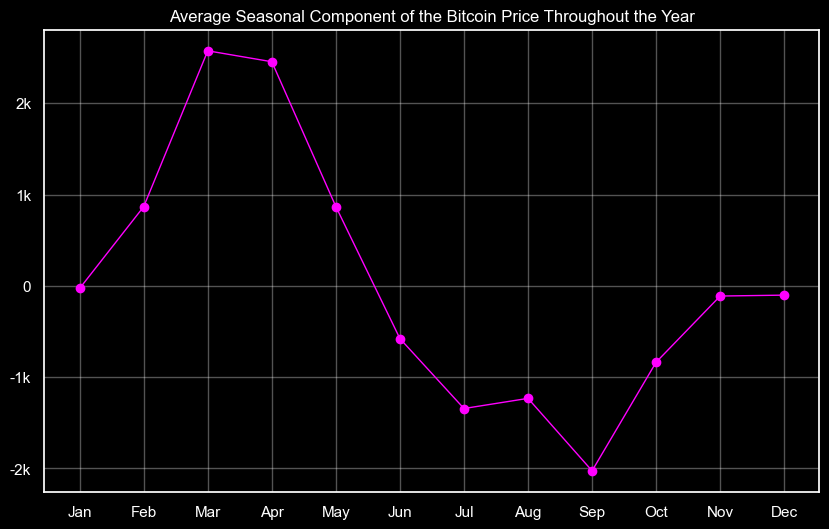

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker="o", color="fuchsia", linewidth=1)

plt.xticks(monthly_avgs.index, [calendar.month_abbr[i] for i in monthly_avgs.index])

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if abs(x) < 1000 and x.is_integer() 
                  else (f"{x:.1f}" if abs(x) < 1 else f"{int(x/1000)}k"))
)

plt.title("Average Seasonal Component of the Bitcoin Price Throughout the Year")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("1_BTC_seasonal")

**Key takeaways:**
- Bitcoin’s average seasonality shows notable changes.
- It typically peaks at the beginning of spring.
- Following this peak, the price generally declines, reaching its lowest point by the end of summer.